In [1]:
import matplotlib.pyplot as plt
import numpy as np

from helperTools import *
from KevinBumperClass import swarmShift_x
from storageRingModeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmSnapShot
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles,get_emittances

from ParticleClass import Swarm
%matplotlib inline
model=make_optimal_solution_model()

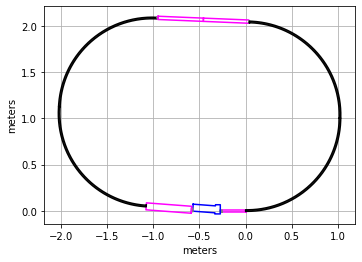

In [2]:
%matplotlib inline
model.lattice_ring.show_lattice()

In [9]:
x_stops_periodic=[1.0,3.0]
T_max_sim=10.0
num_particles_sim=100
phase_space_info,phase_space_info_x_stops=make_phase_space_info(model,x_stops_periodic,-1,T_max_sim,num_particles_sim)

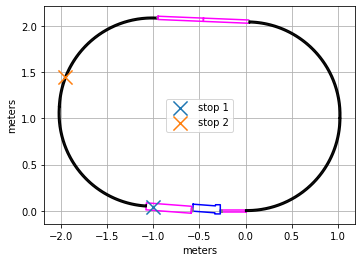

In [11]:
%matplotlib inline
plot_ring_lattice_with_stops(model,phase_space_info,savefig='lattice_with_stops',dpi=300)

2066.352293493691


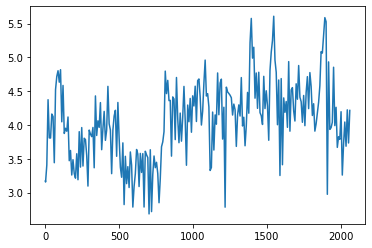

In [12]:
epys,epsz=get_emittances(phase_space_info,0,truncate_x_to_min_survived_T_min=True,T_min=T_max_sim)
plt.plot(phase_space_info_x_stops[0],epys)
plt.show()

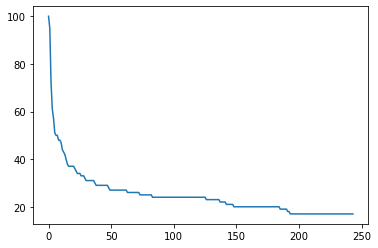

In [14]:
nums=[]
for info in phase_space_info[0][:-5]:
    num=len([particle for particle in info if particle.clipped is False])
    nums.append(num)
plt.plot(nums)


129 2.3446316473852336
129 5.802505526454704


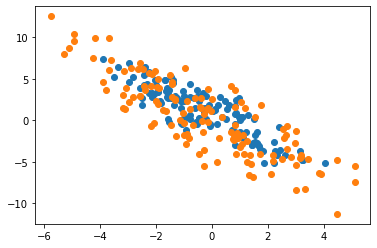

In [121]:
from phaseSpaceAnalysis_Functions import emmitance
y,py=[],[]
for particle in phase_space_info[0][1]:
    if particle.T>T_max_sim and particle.clipped is False:
        y.append(1e3*particle.qo[1])
        py.append(particle.po[1])

print(len(y),emmitance(np.array(y),np.array(py)))
plt.scatter(y,py)


from phaseSpaceAnalysis_Functions import emmitance
y,py=[],[]
for particle in phase_space_info[0][-53]:
    if particle.T>T_max_sim and particle.clipped is False:
        y.append(1e3*particle.qo[1])
        py.append(particle.po[1])

print(len(y),emmitance(np.array(y),np.array(py)))
plt.scatter(y,py)
plt.show()

129 5.598697542642595


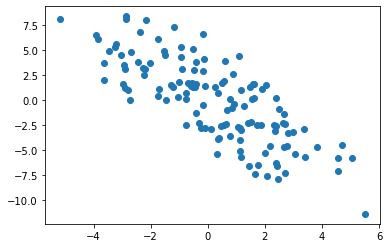

In [117]:
from phaseSpaceAnalysis_Functions import emmitance
y,py=[],[]
for particle in phase_space_info[0][-50]:
    if particle.T>T_max_sim and particle.clipped is False:
        y.append(1e3*particle.qo[1])
        py.append(particle.po[1])

print(len(y),emmitance(np.array(y),np.array(py)))
plt.scatter(y,py)
plt.show()

0.0 0.01696305496543048


[0.009801823855027854,
 0.013871883503864538,
 0.013094942077527915,
 0.013761390151505798,
 0.01271441311306671,
 0.01696305496543048,
 0.015658153333791423,
 0.01219934077669553,
 0.014285573071081746,
 0.012832955224794433,
 0.012635226711571367,
 0.013047307841686721,
 0.01519206320331239,
 0.008050415447985286,
 0.013875242538172256,
 0.009408717002094476,
 0.015373607035605622,
 0.0113948946492689,
 0.013609686096133897,
 0.012045518925749817,
 0.006984166166718784,
 0.013902255209413485,
 0.012844297357134089,
 0.012257799715755253,
 0.011647125937071828,
 0.008132123640178424,
 0.012009375827958305,
 0.0,
 0.015751824150788046,
 0.009787272138390474,
 0.00839146810895807,
 0.011085535053731272,
 0.015247436118591562,
 0.01129216786769617,
 0.010263486259009512,
 0.0,
 0.011958412446941048,
 0.011476031116169792,
 0.009052934067302199,
 0.011250188852007535,
 0.014462921179049877,
 0.009389846068055709,
 0.0159239415441835,
 0.009371915260983108,
 0.011213158599123595,
 0.0,
 0.

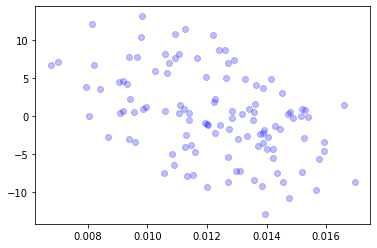

In [13]:
swarmShift_y=0.012
r=.002
def is_inside_circle(particle):
    y,z=particle.qo[1:]
    y-=swarmShift_y
    r_particle=np.sqrt(y**2+z**2)
    return r_particle<r
swarm_init=model.generate_swarm(1000)
y=[particle.qo[1]for particle in phase_space_info[0][0]]
print(min(y),max(y))
py=[particle.po[1] for particle in phase_space_info[0][0]]

plt.scatter(y,py,c='b',alpha=.25)



#
# y=[particle.qo[1]-swarmShift_y for particle in phase_space_info[0][0]  if is_inside_circle(particle)]
# py=[particle.po[1] for particle in phase_space_info[0][0] if is_inside_circle(particle)]
# plt.scatter(y,py,c='r',alpha=.25)
y

In [4]:
from phaseSpaceAnalysis_Functions import trace_swarm_through_ring
swarm_to_trace=model.generate_swarm(120)
swarm_injector_traced,_=trace_swarm_through_ring(model,swarm_to_trace,h=5e-6,T=1e-6,parallel=True)

In [5]:
norm=np.linalg.norm
# y=[particle.qi[1] for particle in swarm_to_trace]
# print(min(y),max(y))
#
y_1=[particle.qo_arr[0][1] for particle in swarm_injector_traced]

y_2=[particle.qo[1] for particle in phase_space_info[0][0]]
# idx=987
idx=35
swarm_injector_traced.particles[idx].qo_arr[0],phase_space_info[0][0][idx].qo
# np.max(np.abs(np.array(y_2)-np.array(y_1)))
# np.argmax(np.abs(np.array(y_2)-np.array(y_1)))


(array([9.99999980e-11, 1.63130057e-02, 1.47726394e-03]),
 array([1.10000000e-09, 1.63130056e-02, 1.47726391e-03]))

In [195]:
phase_space_info[0][0][0].po,swarm_injector_traced.particles[0].po_arr[0]

(array([212.40566006,  13.18367807,  -4.51420755]),
 array([212.40566006,  13.18367807,  -4.51420755]))

In [32]:
def initial_phase_space_info(model,info,h):
    num_particle=len(info[0])
    swarm_to_trace=model.generate_swarm(num_particle)
    swarm_injector_traced,_=trace_swarm_through_ring(model,swarm_to_trace,h=h,T=1e-6,parallel=True)
    x_start=max([particle.qo_arr[0][0] for particle in swarm_injector_traced])
    #match up paremter
    print(info[0][35].T,info[0][35].revolutions)
    # for particle_ring,particle_injector in zip(info[0],swarm_injector_traced):
    #     particle_injector.T=particle_ring.T
    #     particle_injector.revolutions=particle_ring.revolutions

    snap=SwarmSnapShot(swarm_injector_traced,x_start+1e-9)
    return snap.particles
initial_info=initial_phase_space_info(model,phase_space_info[0][1:],7.5e-6)

0 0.03520220435693652


In [31]:
initial_info[35].po

array([204.92514423, -12.5541996 ,  -7.06547248])

In [20]:
phase_space_info[0][1][6].E,phase_space_info[0][4][6].E
for particle in phase_space_info[0][0]:
    print(particle.clipped)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False


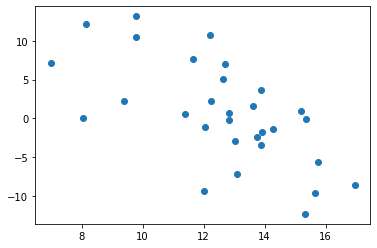

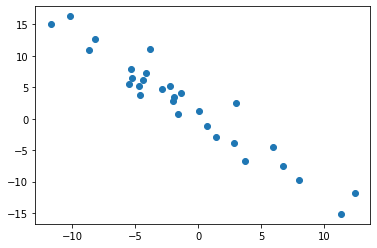

In [14]:
y=1e3*np.array([particle.qo[1] for particle in phase_space_info[0][0]])
py=np.array([particle.po[1] for particle in phase_space_info[0][0]])
plt.scatter(y,py)
plt.show()
y=1e3*np.array([particle.qo[1] for particle in phase_space_info[0][1]])
py=np.array([particle.po[1] for particle in phase_space_info[0][1]])
plt.scatter(y,py)
plt.show()


In [54]:
phase_space_info[0][0][0].qo

array([ 1.        ,  0.0021854 , -0.00800746])

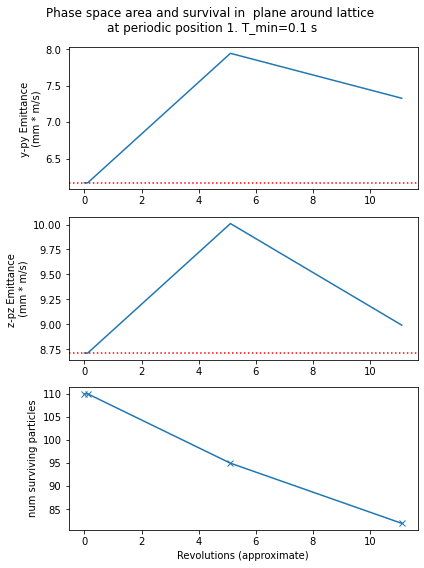

In [92]:
TMin=.1
is_valid=lambda particle: particle.T>TMin and  particle.clipped is False

periodic_stop_index=0
x_stops=phase_space_info_x_stops[periodic_stop_index]
revs_stops=np.array(x_stops)/model.lattice_ring.total_length
revs_stops=np.append(0,revs_stops)


particles_intial=[particle for particle in phase_space_info[0][0] if is_valid(particle)]
num_particles_at_stops=[len(particles_intial)]

epsy_intial,epsz_intial=emittance_from_particles(particles_intial,TMin)
epsy_stops,epsz_stops=[epsy_intial],[epsz_intial]
for particles_at_stop in phase_space_info[periodic_stop_index]:
    # print('------------')
    num_particles_valid=len([particle for particle in particles_at_stop if is_valid(particle)])
    num_particles_at_stops.append(num_particles_valid)
    # print(num_particles_valid)
    epsy,epsz=emittance_from_particles(particles_at_stop,TMin)
    epsy_stops.append(epsy)
    epsz_stops.append(epsz)

    # plt.scatter(y,py)
    # plt.show()
    # plt.scatter(z,pz)
    # plt.show()
trim_from_end=2
revs_stops=revs_stops[:-trim_from_end]
epsy_stops=epsy_stops[:-trim_from_end]
epsz_stops=epsz_stops[:-trim_from_end]
num_particles_at_stops=num_particles_at_stops[:-trim_from_end]

y_plot_vals=[epsy_stops,epsz_stops]
x_plot_vals=[revs_stops]*len(y_plot_vals)
axhline_vals=[epsy_intial,epsz_intial]
titles=['y-py','z-pz']
save=False

fig=plt.figure(figsize=(6,8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, sharex = ax1)
ax3 = plt.subplot(313, sharex = ax1)
axes_phase=[ax1,ax2]
title_string="Phase space area and survival in  plane around lattice \n"
title_string+="at periodic position "+str(periodic_stop_index+1)+". T_min="+str(TMin)+" s"
fig.suptitle(title_string)
for ax,x,y,axh_val,title in zip(axes_phase,x_plot_vals,y_plot_vals,axhline_vals,titles):
    # ax_title_string="Phase space area and survival in "+title+" \n plane around lattice"
    # title_string+="at periodic position "+str(periodic_stop_index+1)
    # fig.suptitle(title_string)
    ax.plot(x,y)
    ax.axhline(y=axh_val,c='r',linestyle=':')
    ax.set_ylabel(str(title)+" Emittance \n (mm * m/s) ")

ax3.plot(revs_stops,num_particles_at_stops,marker='x')
ax3.set_xlabel("Revolutions (approximate)")
ax3.set_ylabel("num surviving particles")
plt.tight_layout()
if save:
    plt.savefig('emittance_plot_'+title+'_stop_'+str(periodic_stop_index+1)+"_Tmin_"+str(round(TMin)),dpi=200)
plt.show()




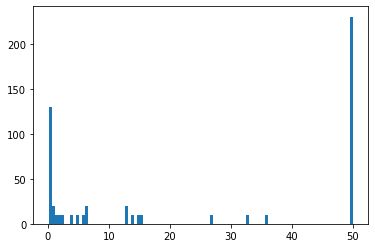

In [209]:
times=[particle.T for particle in phase_space_info[0][-2] if particle.T>.1]
plt.hist(times,bins=100)
plt.show()

In [99]:
phase_space_info[0][2][0].revolutions

0

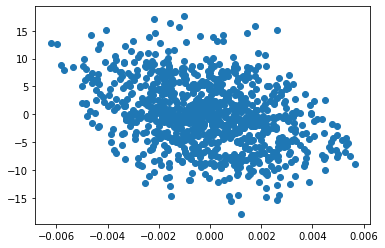

In [202]:
info=phase_space_info[0]
swarm=model.generate_Swarm(1000)
yi,pyi=[],[]
for particle in swarm:
    yi.append(particle.qi[1])
    pyi.append(particle.pi[1])
plt.scatter(yi,pyi)

plt.show()

In [42]:
len(x_stops)

4

In [74]:
# is_valid
for particle in phase_space_info[0]:
    if particle.po is not None and abs(particle.po[1])>30.0:
        print(particle.qi,particle.T)

[-0.74541305  0.00101559 -0.00359697] 0.003510000000000017
[-0.74427128  0.01577179  0.00346633] 0.002917500000000007
[-0.74450207  0.01132799  0.01274599] 0.003637500000000019
[-0.74462337  0.01053211 -0.00252951] 0.002917500000000007
[-0.74406446  0.01210403  0.00418675] 0.002977500000000008
[-0.74511748  0.00123129 -0.01029874] 0.003502500000000017
[-0.74541305  0.00101559 -0.00359697] 0.003510000000000017
[-0.74427128  0.01577179  0.00346633] 0.002917500000000007
[-0.74450207  0.01132799  0.01274599] 0.003637500000000019
[-0.74462337  0.01053211 -0.00252951] 0.002917500000000007
[-0.74406446  0.01210403  0.00418675] 0.002977500000000008
[-0.74511748  0.00123129 -0.01029874] 0.003502500000000017
[-0.74541305  0.00101559 -0.00359697] 0.003510000000000017
[-0.74427128  0.01577179  0.00346633] 0.002917500000000007
[-0.74450207  0.01132799  0.01274599] 0.003637500000000019
[-0.74462337  0.01053211 -0.00252951] 0.002917500000000007
[-0.74406446  0.01210403  0.00418675] 0.0029775000000000

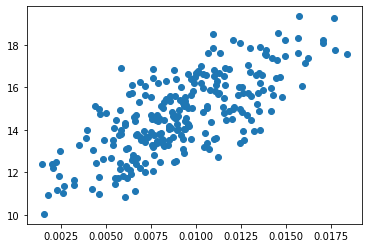

In [5]:
min_time=T-1.0
particles=[particle for particle in swarmTracedRing.particles if particle.T>min_time]
y= np.array([particle.qi[1] for particle in  particles])
py=np.array([particle.pi[1] for particle in particles])
plt.scatter(y,py)
plt.show()



In [ ]:
xMax=max([particle.qoArr[-1,0] for particle in swarmTracedRing])
revsMax=int(xMax/model.latticeRing.totalLength)-1
min_Survival_Time=min_time
x0=1.5
epsy_list=[]
epsz_list=[]
for revs in range(0,revsMax+1,revsMax//10):
    print('------------------revs--------')
    x=x0+revs*model.latticeRing.totalLength
    t=time.time()
    snap=SwarmSnapShot(swarmTracedRing.copy(),x,min_Survival_T=min_Survival_Time)
    phaseSpace=snap.get_Surviving_Particle_PhaseSpace_Coords()
    y,py=phaseSpace[:,1],phaseSpace[:,-2]
    z,pz=phaseSpace[:,2],phaseSpace[:,-1]
    # plt.hist(pz)
    # plt.xlim([-15,15])
    # plt.show()
    # plt.hist(py)
    # plt.xlim([-15,15])
    # plt.show()
    epsy_list.append(emmitance(y,py))
    epsz_list.append(emmitance(z,pz))
    plt.scatter(y,py)
    plt.xlim([-.005,.005])
    plt.ylim([-15,15])
    plt.show()
    plt.scatter(z,pz)
    plt.xlim([-.005,.005])
    plt.ylim([-15,15])
    plt.show()

In [17]:
print(swarmTracedRing.particles[0].qf)

None
